In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:5]


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# building the vocabulary with mapping from characters to integers and vice-versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# building the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # cropping and appending

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
# utility function to compare manual gradients to pytorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt ==t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} |   exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [17]:
n_embd = 10
n_hidden = 200



g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden, generator = g) * 0.1     # This is useless we are adding to see the gradient

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1  
b2 = torch.randn(vocab_size, generator = g)* 0.1 

# batch normalization
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1



parameters = [C, W1, b1, W2, b2, bngain, bnbias] 
print(sum(p.nelement() for p in parameters)) # getting the number of parameters
for p in parameters:
    p.requires_grad = True

12297


In [18]:
batch_size = 32
n = batch_size # shorter variable name

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]   # batch X, Y

In [19]:
# forward pass, split into smaller steps to see backward prop one at a time

emb  = C[Xb]    # embedding the characters into vectors
embcat = emb.view(emb.shape[0], -1)     # concatenating the vectors

# Linear layer1
hprebn =embcat @ W1 + b1    # hidden layer pre-activation and normalization

#batchnorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani 
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(0, keepdim = True)     # bessel's corection
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain*bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)  # hidden layer

# Linear layer 2
logits = h @ W2 + b2    # output layer

# cross entropy loss ( same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes  # subtracting the max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims = True)
counts_sum_inv = counts_sum**-1     #Interesting fact: using 1/counts_sum is not good for getting exact backprop
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()


# pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv,
          bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.8279, grad_fn=<NegBackward0>)

In [20]:
probs.shape

torch.Size([32, 27])

In [65]:
# Exercise 1: backprop through the whole thing manually, backpropagationg through exactly all of the variables
# as they are defined in the forward pass aboce, one by one

# logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
# probs
dprobs = (1.0 / probs) * dlogprobs
# counts_sum_inv
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)
dcounts = counts_sum_inv * dprobs
# counts_sum 
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
# counts
dcounts +=  torch.ones_like(counts) * dcounts_sum
# dnorm_logits
dnorm_logits = counts * dcounts
#dlogits
dlogits = dnorm_logits.clone()
#dlogit_maxes
dlogit_maxes = (-dnorm_logits).sum(1, keepdim = True) # we get close to zero here
# logits again
dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes
# dh
dh = dlogits @ W2.T 
# W2
dW2 = h.T @ dlogits
# b2
db2 = dlogits.sum(0)
# hpreact
dhpreact = (1 - h**2) * dh
# dbngain
dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
# dbnraw 
dbnraw = (bngain * dhpreact)
# bnbias
dbnbias = dhpreact.sum(0, keepdim = True)
# bndiff
dbndiff = bnvar_inv * dbnraw
# bnvar_inv
dbnvar_inv = (bndiff*dbnraw).sum(0, keepdim = True)
#bnvar
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
#bndiff2
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
# bndiff
dbndiff += (2 * bndiff) * dbndiff2
#bhprebn
dhprebn = dbndiff.clone()
# bnmeani
dbnmeani = (-dbndiff).sum(0)
#hprebn
dhprebn += (1.0/n) * torch.ones_like(hprebn) * dbnmeani
#embcat
dembcat = dhprebn @ W1.T
# W1
dW1 = embcat.T @ dhprebn
# b1
db1 = dhprebn.sum(0)
#emb
demb = dembcat.view(emb.shape)
# C
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]


cmp('logprobs', dlogprobs,  logprobs)
cmp('probs', dprobs,  probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits', dlogits, logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bndiff', dbndiff, bndiff)
cmp('bnvarinv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        |   exact: True  | approximate: True  | maxdiff: 0.0
probs           |   exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  |   exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      |   exact: True  | approximate: True  | maxdiff: 0.0
counts          |   exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     |   exact: True  | approximate: True  | maxdiff: 0.0
logits          |   exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     |   exact: True  | approximate: True  | maxdiff: 0.0
h               |   exact: True  | approximate: True  | maxdiff: 0.0
W2              |   exact: True  | approximate: True  | maxdiff: 0.0
b2              |   exact: True  | approximate: True  | maxdiff: 0.0
hpreact         |   exact: True  | approximate: True  | maxdiff: 0.0
bngain          |   exact: True  | approximate: True  | maxdiff: 0.0
bnraw           |   exact: True  | approximate: True  | maxdiff: 0.0
bnbias          |   exact: True  |

In [66]:
# Exercise 2 : backprop through cross_entropy but all n one go
# to complete this challenge, we look at the mathematical expression of the loss.
# in other words, we take the derivative, simplify the expression and write it out

# forward  pass - before:
# logit_maxes = logits.max(1, keepdim = True).values
# norm_logits = logits - logit_maxes  # subtracting the max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims = True)
# counts_sum_inv = counts_sum**-1     #Interesting fact: using 1/counts_sum is not good for getting exact backprop
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# forward pass now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.827936887741089 diff: -2.384185791015625e-07


In [ ]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

# THe amount to which you mispredict is the amount of pull to the right answer

logits          |   exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


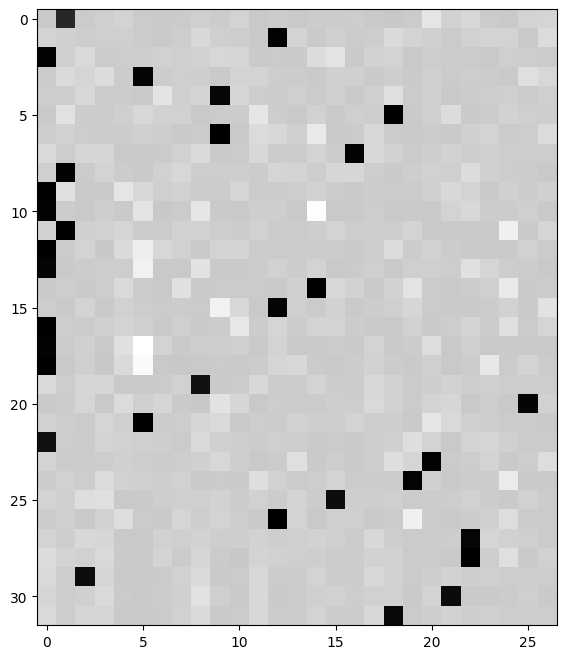

In [ ]:
plt.figure(figsize = (8, 8))
plt.imshow(dlogits.detach(), cmap = 'gray')


In [71]:
# Exercise 3: backprop through batchnorm but all in one go


# forward pass

# before
# bnmeani = 1/n * hprebn.sum(0, keepdim = True)
# bndiff = hprebn - bnmeani 
# bndiff2 = bndiff**2
# bnvar = 1/(n-1) * bndiff2.sum(0, keepdim = True)     # bessel's corection
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain*bnraw + bnbias

# now = 
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim = True)) / torch.sqrt(hprebn.var(0, keepdim = True, unbiased = True) + 1e-5)
print('max_diff:', (hpreact_fast - hpreact).abs().max())

max_diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass
# calculate dhprebn given dhpreact (we ignore gamma and beta for now)

dhprebn = bngain * bnvar_inv / n * (n* dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)


hprebn          |   exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [75]:
# Exercise 4: Putting it all together
# training the mlp neural network with our own backward pass

# init
n_embd = 10
n_hidden = 200



g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden, generator = g) * 0.1     # This is useless we are adding to see the gradient

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1  
b2 = torch.randn(vocab_size, generator = g)* 0.1 

# batch normalization
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1



parameters = [C, W1, b1, W2, b2, bngain, bnbias] 
print(sum(p.nelement() for p in parameters)) # getting the number of parameters
for p in parameters:
    p.requires_grad = True

# optimization
max_steps = 200000
batch_size = 32
n = batch_size
lossi = []


# use this context manager for efficieny once backward pass is written
with torch.no_grad():
    for i in range(max_steps):

        # minibatch_construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
        Xb, Yb = Xtr[ix], Ytr[ix]   # batch X, Y

        emb  = C[Xb]    # embedding the characters into vectors
        embcat = emb.view(emb.shape[0], -1)     # concatenating the vectors

        # Linear layer1
        hprebn =embcat @ W1 + b1    # hidden layer pre-activation and normalization

        #batchnorm layer
        bnmean =  hprebn.mean(0, keepdim = True)
        bnvar = hprebn.var(0, keepdim = True, unbiased = True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) *bnvar_inv
        hpreact = bngain*bnraw + bnbias

        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2    # output layer
        loss = F.cross_entropy(logits, Yb)

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() #use for comparison, delete later

        # manual backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        #2nd layer
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
        dbnbias = dhpreact.sum(0, keepdim = True)
        dhprebn = bngain * bnvar_inv / n * (n* dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embeddding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad
            p.data += -lr * grad
        
        # track stats:
        if i %10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())  

        # if i >= 100:
        #     break


12297
      0/ 200000: 3.8279
  10000/ 200000: 2.1609
  20000/ 200000: 2.4227
  30000/ 200000: 2.4362
  40000/ 200000: 2.0088
  50000/ 200000: 2.4084
  60000/ 200000: 2.4508
  70000/ 200000: 2.1090
  80000/ 200000: 2.3592
  90000/ 200000: 2.2353
 100000/ 200000: 1.9750
 110000/ 200000: 2.3438
 120000/ 200000: 2.0156
 130000/ 200000: 2.4772
 140000/ 200000: 2.3107
 150000/ 200000: 2.1108
 160000/ 200000: 1.9497
 170000/ 200000: 1.8004
 180000/ 200000: 2.0284
 190000/ 200000: 1.8848


In [ ]:
# checking gradients
# for p, g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

(27, 10)        |   exact: False | approximate: True  | maxdiff: 1.5832483768463135e-08
(30, 200)       |   exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(200,)          |   exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(200, 27)       |   exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           |   exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        |   exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
(1, 200)        |   exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [76]:
# calibrating the batch norm at the end


with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat@W1 + b1
    # measure the mean/std over the entire traning set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [77]:
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat@W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0673813819885254
val 2.1062190532684326


In [78]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact  = emb.view(1, -1) @ W1 + b1
        hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

carla.
fati.
harlikimri.
reet.
khalaysie.
mahnee.
delynn.
jareei.
nellara.
chaily.
kaleigh.
ham.
joce.
quinn.
shoison.
jadbi.
wavero.
dearyn.
kai.
eveilsan.
